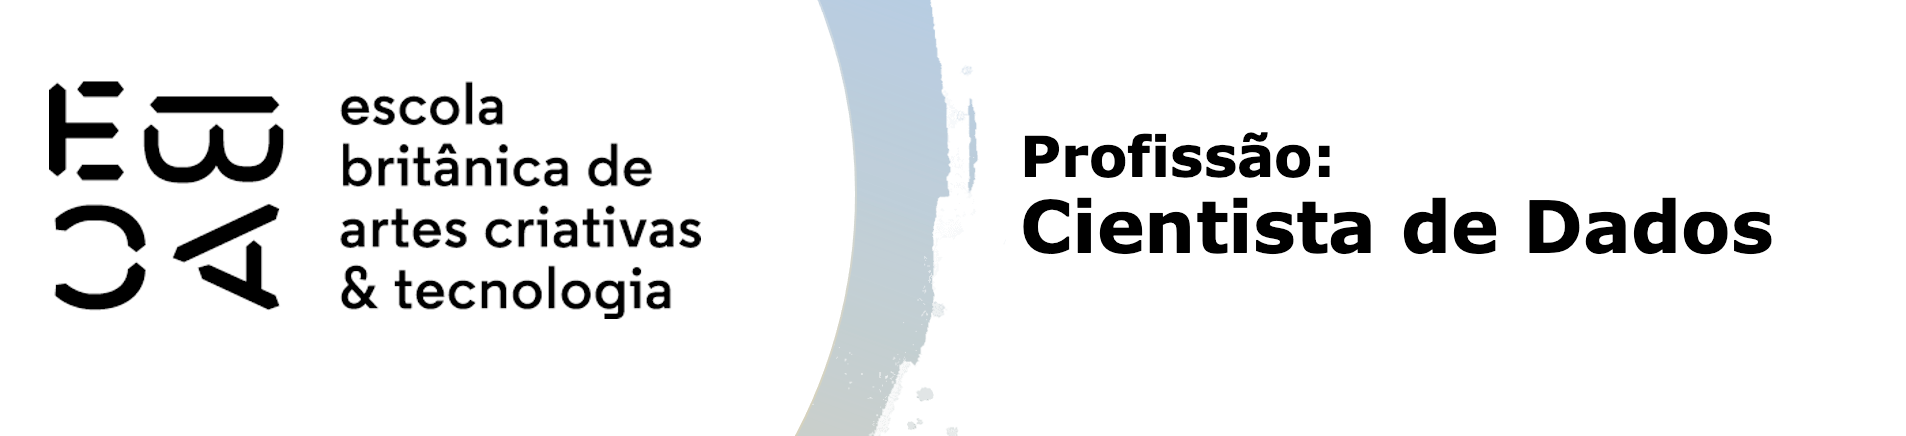

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from scipy.stats import t
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression


try:
    df = pd.read_feather('../Dados/credit_scoring.ftr')
except FileNotFoundError:
    df = pd.read_feather('credit_scoring.ftr')

df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [11]:
# Convertendo data_ref para datetime se necessário
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Identificando as safras
safras = sorted(df['data_ref'].unique())
print(f"Total de safras: {len(safras)}")
print(f"Safras disponíveis: {safras}")

# Separando as 3 últimas safras para OOT
safras_oot = safras[-3:]
print(f"Safras OOT: {safras_oot}")

# Criando as bases de treino e teste (OOT)
df_train = df[~df['data_ref'].isin(safras_oot)].copy()
df_oot = df[df['data_ref'].isin(safras_oot)].copy()

print(f"Shape Treino: {df_train.shape}")
print(f"Shape OOT: {df_oot.shape}")

# Removendo variáveis que não devem ser usadas na modelagem
vars_to_drop = ['data_ref', 'index']
# Mantendo data_ref apenas para controle se necessário, mas removendo da lista de features
features = [col for col in df.columns if col not in vars_to_drop and col != 'mau']

print(f"Variáveis explicativas: {features}")

Total de safras: 15
Safras disponíveis: [Timestamp('2015-01-01 00:00:00'), Timestamp('2015-02-01 00:00:00'), Timestamp('2015-03-01 00:00:00'), Timestamp('2015-04-01 00:00:00'), Timestamp('2015-05-01 00:00:00'), Timestamp('2015-06-01 00:00:00'), Timestamp('2015-07-01 00:00:00'), Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-01 00:00:00'), Timestamp('2015-10-01 00:00:00'), Timestamp('2015-11-01 00:00:00'), Timestamp('2015-12-01 00:00:00'), Timestamp('2016-01-01 00:00:00'), Timestamp('2016-02-01 00:00:00'), Timestamp('2016-03-01 00:00:00')]
Safras OOT: [Timestamp('2016-01-01 00:00:00'), Timestamp('2016-02-01 00:00:00'), Timestamp('2016-03-01 00:00:00')]
Shape Treino: (600000, 15)
Shape OOT: (150000, 15)
Variáveis explicativas: ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [12]:
# Número de linhas e linhas por mês
print(f"Total de linhas na base completa: {df.shape[0]}")
print("\nLinhas por mês (data_ref):")
print(df['data_ref'].value_counts().sort_index())

# Descritiva univariada
print("\n--- Descritiva Variáveis Quantitativas ---")
# Selecionando apenas colunas numéricas dentro das features
num_features = [col for col in features if df_train[col].dtype in ['int64', 'float64']]
print(df_train[num_features].describe())

print("\n--- Descritiva Variáveis Qualitativas ---")
# Selecionando colunas categóricas
cat_features = [col for col in features if col not in num_features]
for col in cat_features:
    print(f"\nVariável: {col}")
    print(df_train[col].value_counts(normalize=True))
    print(f"Valores nulos: {df_train[col].isnull().sum()}")

Total de linhas na base completa: 750000

Linhas por mês (data_ref):
data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64

--- Descritiva Variáveis Quantitativas ---
          qtd_filhos          idade  tempo_emprego  qt_pessoas_residencia  \
count  600000.000000  600000.000000  499125.000000          600000.000000   
mean        0.433210      43.798530       7.747992               2.212122   
std         0.739869      11.230659       6.688576               0.903757   
min         0.000000      22.000000       0.117808               1.000000   
25%         0.000000      34.000000       3.049315               2.000000   
50%         0.000000      43.000000       6.046575               2.000000   
75%         1

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [13]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

C:\Users\Admin\AppData\Local\Temp\ipykernel_4736\1592563710.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)
C:\Users\Admin\AppData\Local\Temp\ipykernel_4736\1592563710.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)
C:\Users\Admin\AppData\Local\Temp\ipykernel_4736\1592563710.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)
C:\Users\Admi

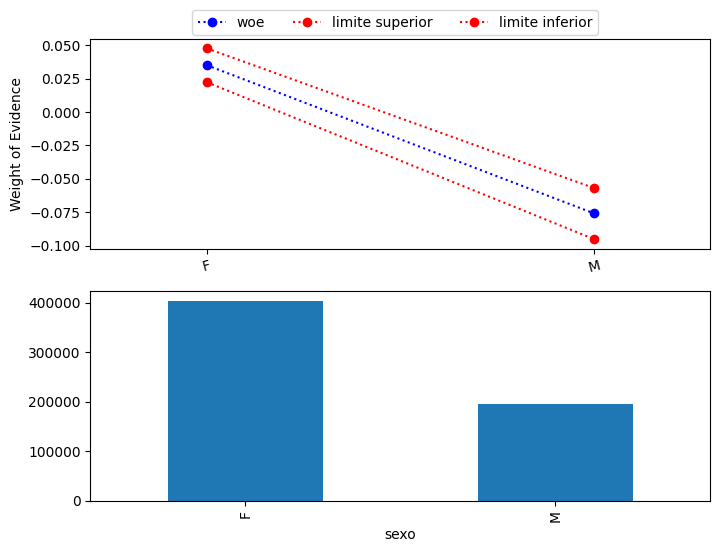

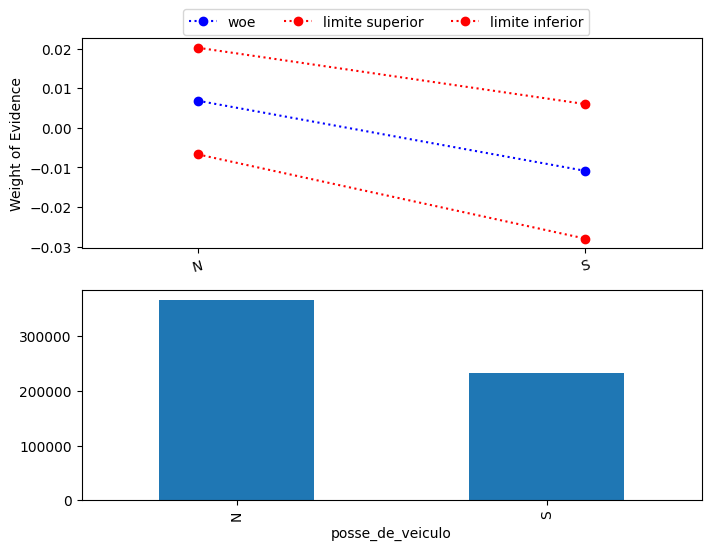

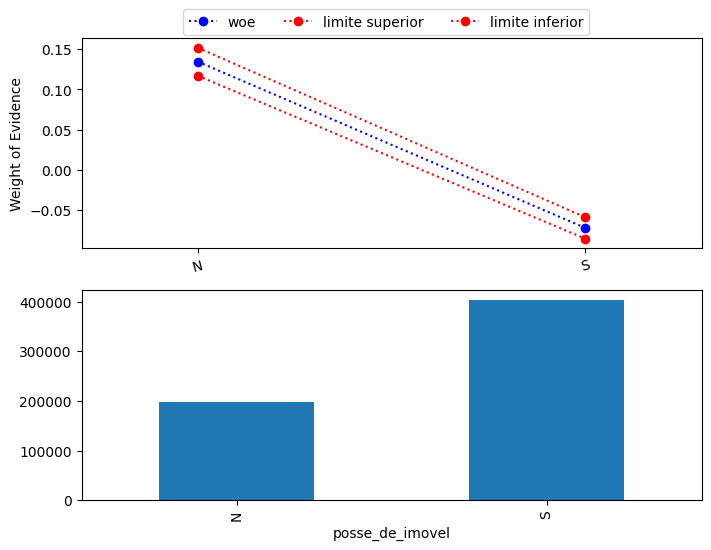

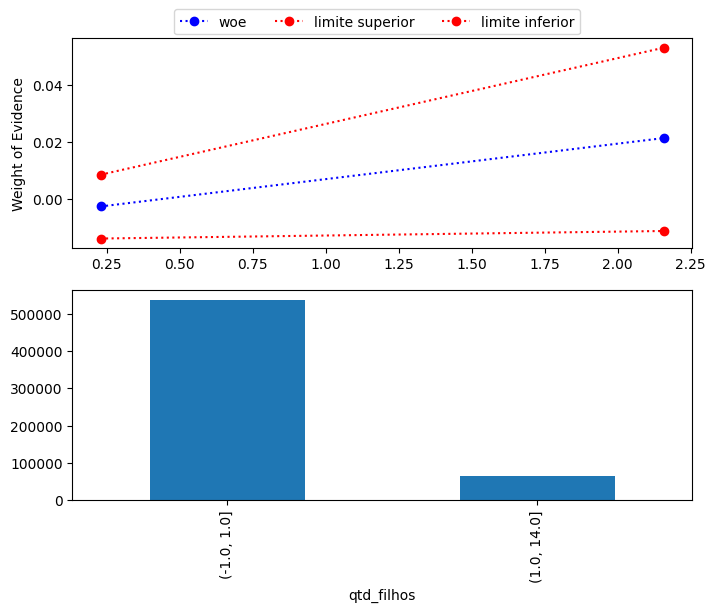

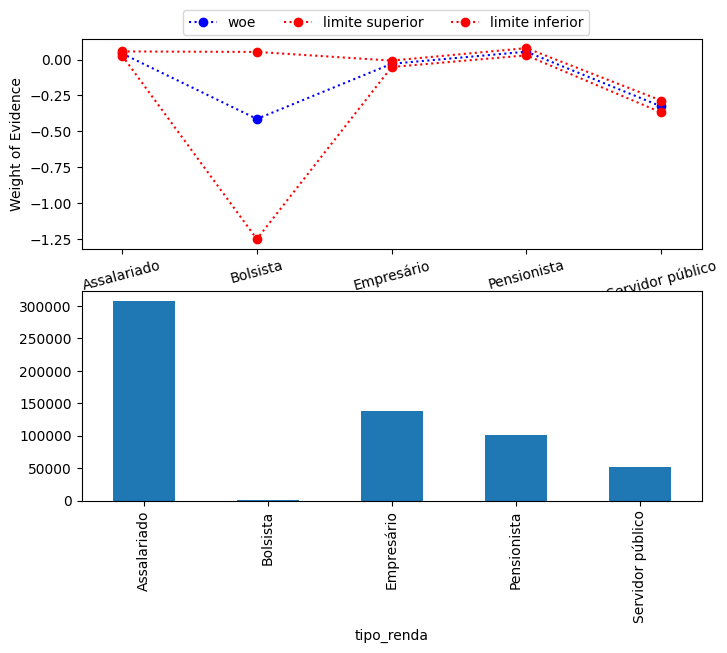

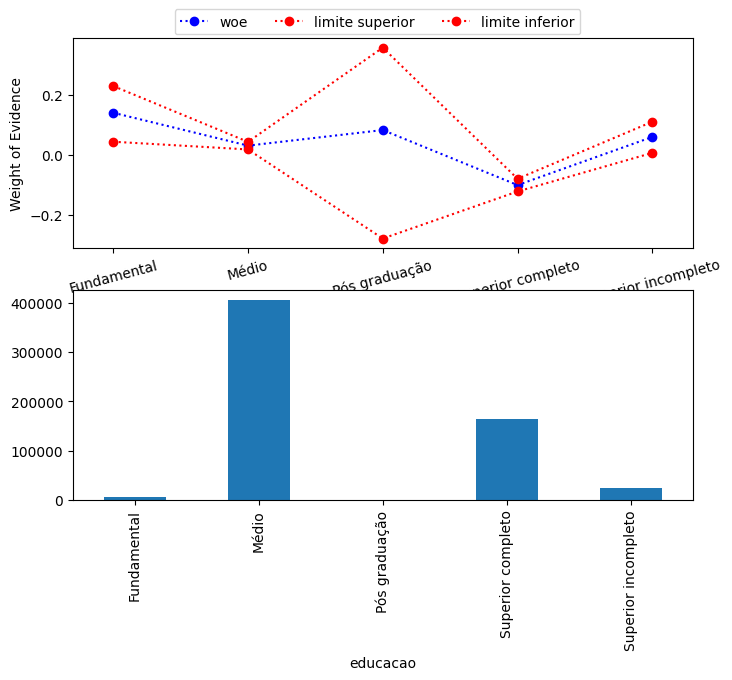

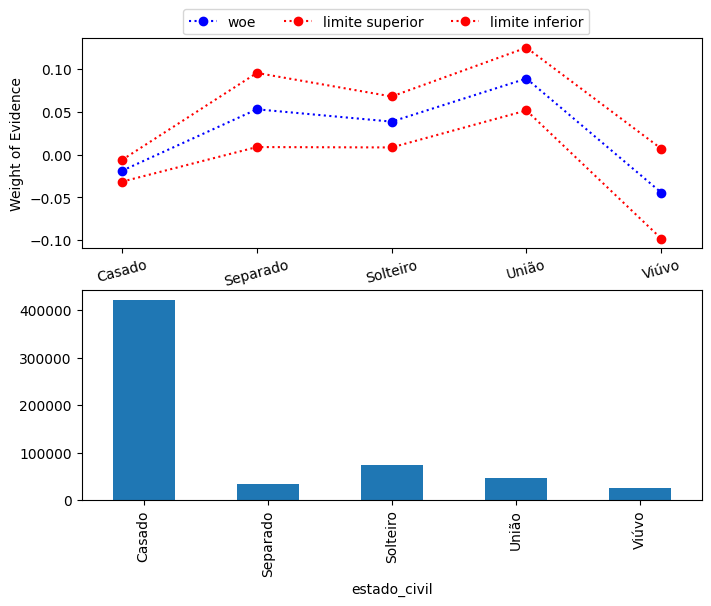

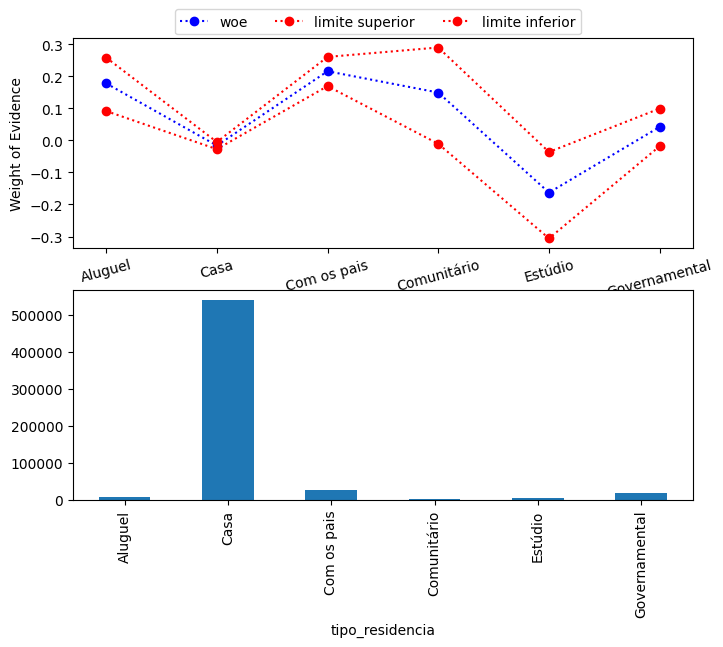

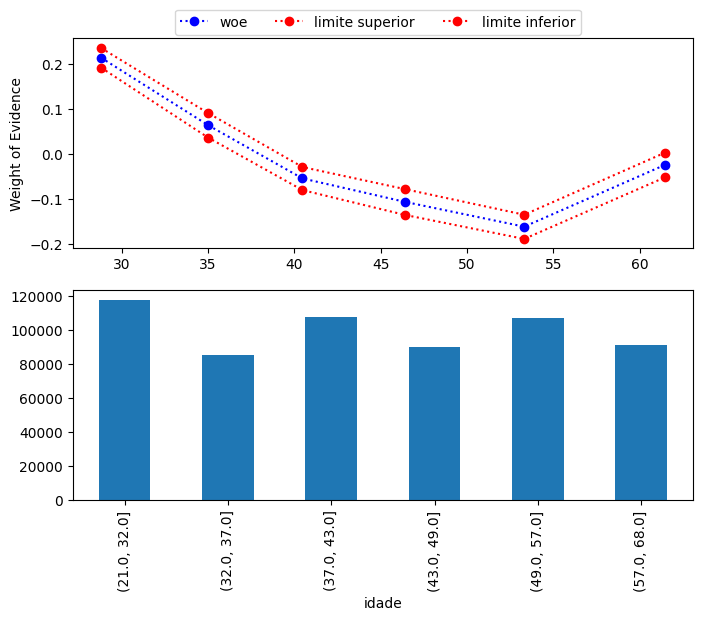

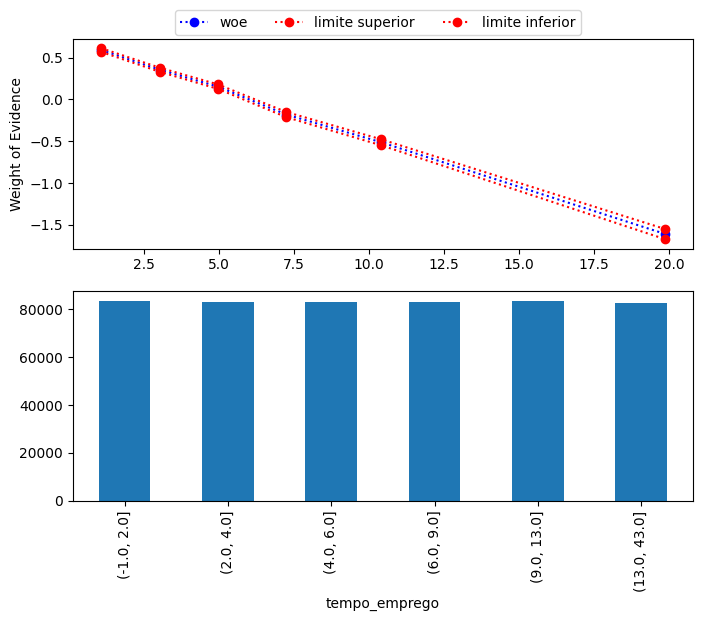

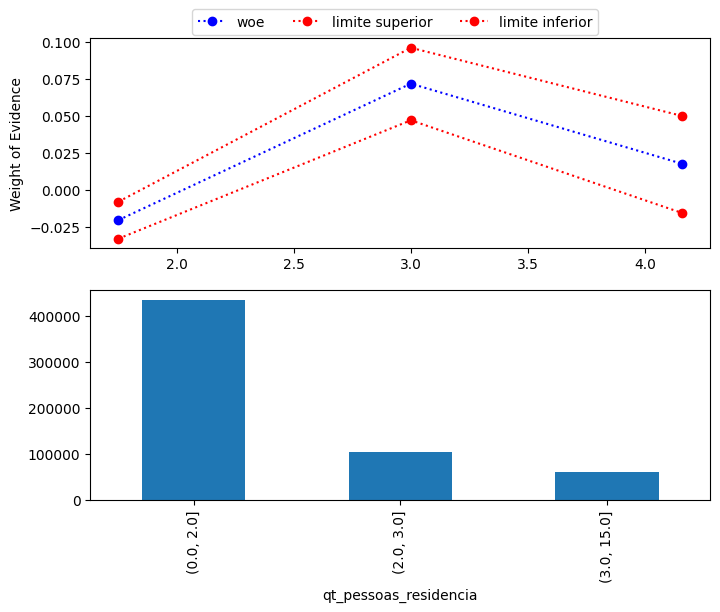

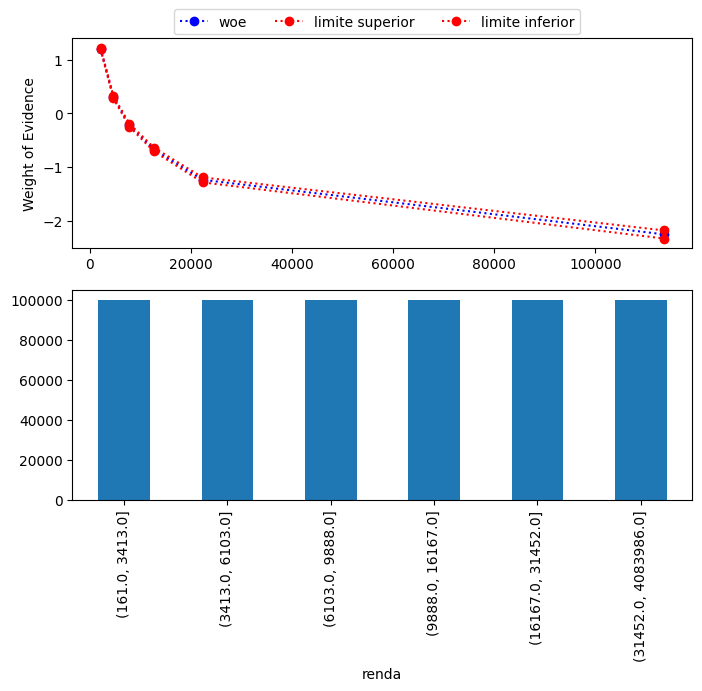

In [14]:
for var in features:
    if var in cat_features:
        biv_discreta(var, df_train)
    else:
        biv_continua(var, 6, df_train)

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [16]:
import statsmodels.formula.api as smf

df_train_mod = df_train.copy()
df_oot_mod = df_oot.copy()

for col in num_features:
    median_val = df_train_mod[col].median()
    df_train_mod[col] = df_train_mod[col].fillna(median_val)
    df_oot_mod[col] = df_oot_mod[col].fillna(median_val)

for col in cat_features:
    mode_val = df_train_mod[col].mode()[0]
    # Convertendo para string para evitar problemas com categorias
    df_train_mod[col] = df_train_mod[col].astype(str).fillna(str(mode_val))
    df_oot_mod[col] = df_oot_mod[col].astype(str).fillna(str(mode_val))

df_train_mod['mau'] = df_train_mod['mau'].astype(int)
df_oot_mod['mau'] = df_oot_mod['mau'].astype(int)

formula_terms = []
for col in features:
    if col in cat_features:
        formula_terms.append(f"C({col})")
    else:
        formula_terms.append(col)

formula = 'mau ~ ' + ' + '.join(formula_terms)

# Ajustando o modelo de Regressão Logística
model = smf.logit(formula, data=df_train_mod).fit()

# Resumo do modelo
print(model.summary())

# Equação preditiva (coeficientes)
print("\nEquação Preditiva (Coeficientes):")
print(model.params)

Optimization terminated successfully.
         Current function value: 0.208136
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                    mau   No. Observations:               600000
Model:                          Logit   Df Residuals:                   599974
Method:                           MLE   Df Model:                           25
Date:                sex, 19 dez 2025   Pseudo R-squ.:                 0.09469
Time:                        17:16:28   Log-Likelihood:            -1.2488e+05
converged:                       True   LL-Null:                   -1.3794e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -1.1296      0.192

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [17]:
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.stats import ks_2samp

def evaluate_model(model, df, target_col='mau', dataset_name='Treino'):
    # Predição de probabilidade
    y_prob = model.predict(df)
    # Predição de classe (cutoff 0.5)
    y_pred = (y_prob >= 0.5).astype(int)
    y_true = df[target_col]
    
    # Acurácia
    acc = accuracy_score(y_true, y_pred)
    
    # AUC e Gini
    auc = roc_auc_score(y_true, y_prob)
    gini = 2 * auc - 1
    
    # KS
    # KS é a maior diferença entre as distribuições acumuladas de probabilidade de bons e maus
    data_ks = pd.DataFrame({'prob': y_prob, 'target': y_true})
    ks_stat, ks_pval = ks_2samp(data_ks.loc[data_ks['target'] == 1, 'prob'], 
                                data_ks.loc[data_ks['target'] == 0, 'prob'])
    
    print(f"--- Avaliação: {dataset_name} ---")
    print(f"Acurácia: {acc:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"Gini: {gini:.4f}")
    print(f"KS: {ks_stat:.4f}")
    print("-" * 30)
    
    return {'acc': acc, 'gini': gini, 'ks': ks_stat}

metrics_train = evaluate_model(model, df_train_mod, dataset_name='Treino')

metrics_oot = evaluate_model(model, df_oot_mod, dataset_name='OOT')

--- Avaliação: Treino ---
Acurácia: 0.9389
AUC: 0.7656
Gini: 0.5312
KS: 0.3942
------------------------------
--- Avaliação: OOT ---
Acurácia: 0.8533
AUC: 0.7230
Gini: 0.4459
KS: 0.3262
------------------------------


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [18]:
print(df_train.isnull().sum())

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            100875
qt_pessoas_residencia         0
renda                         0
mau                           0
bom                           0
dtype: int64


### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

class OutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor
        self.limits = {}
        
    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            for col in X.select_dtypes(include=np.number).columns:
                q1 = X[col].quantile(0.25)
                q3 = X[col].quantile(0.75)
                iqr = q3 - q1
                self.limits[col] = (q1 - self.factor * iqr, q3 + self.factor * iqr)
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X_copy = X.copy()
            for col, (low, high) in self.limits.items():
                if col in X_copy.columns:
                    X_copy[col] = X_copy[col].clip(lower=low, upper=high)
            return X_copy
        return X

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [20]:


numeric_features = [col for col in features if df_train[col].dtype in ['int64', 'float64']]
categorical_features = [col for col in features if col not in numeric_features]


num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('outlier_capper', OutlierCapper(factor=1.5)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)) 
])


cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numeric_features),
        ('cat', cat_pipeline, categorical_features)
    ]
)

full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(score_func=f_classif, k=5)), 
    ('model', LogisticRegression(max_iter=1000))
])

X_train = df_train[features]
y_train = df_train['mau']
X_oot = df_oot[features]
y_oot = df_oot['mau']

# Treinando
full_pipeline.fit(X_train, y_train)

print("Pipeline treinado com sucesso.")

Pipeline treinado com sucesso.


In [21]:
y_pred_oot = full_pipeline.predict(X_oot)
y_prob_oot = full_pipeline.predict_proba(X_oot)[:, 1]

acc = accuracy_score(y_oot, y_pred_oot)
auc = roc_auc_score(y_oot, y_prob_oot)
gini = 2 * auc - 1

print(f"--- Avaliação Pipeline (OOT) ---")
print(f"Acurácia: {acc:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Gini: {gini:.4f}")

--- Avaliação Pipeline (OOT) ---
Acurácia: 0.8533
AUC: 0.6386
Gini: 0.2772


# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [22]:
df = pd.read_feather('..\Dados\credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [23]:
from pycaret.classification import *

s = setup(data=df_train, target='mau', test_data=df_oot,
          ignore_features=['data_ref', 'index'],
          session_id=123)

models()

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(750000, 16)"
4,Transformed data shape,"(750000, 31)"
5,Transformed train set shape,"(600000, 31)"
6,Transformed test set shape,"(150000, 31)"
7,Ignore features,2
8,Numeric features,6
9,Categorical features,7


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [24]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


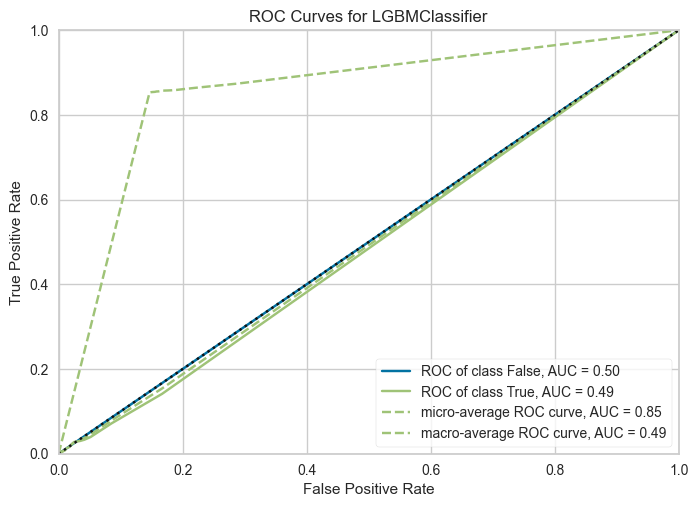

In [25]:
plot_model(lgbm, plot='auc')

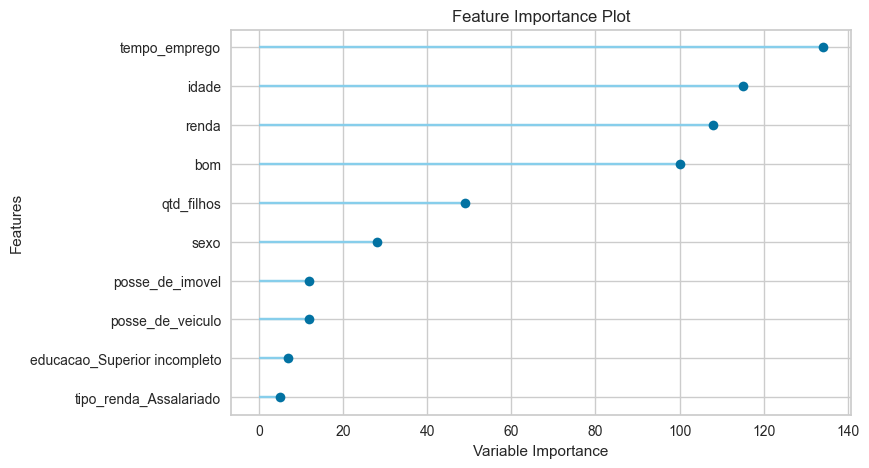

In [26]:
plot_model(lgbm, plot='feature')

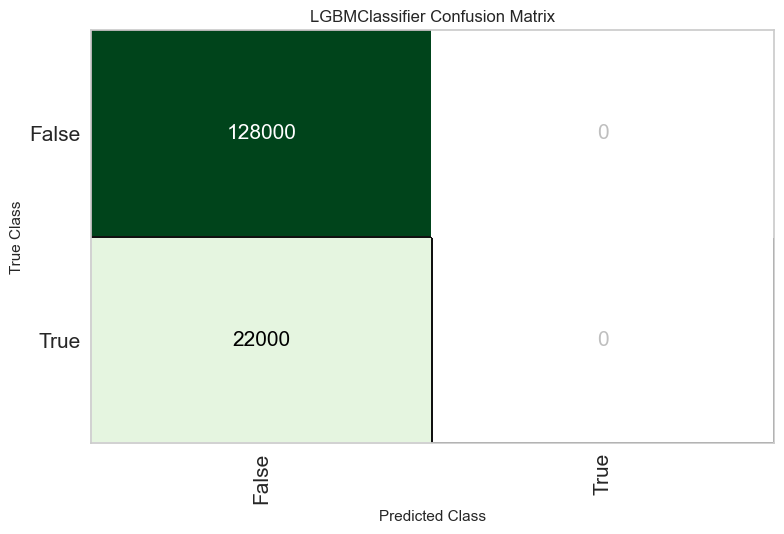

In [27]:
plot_model(lgbm, plot='confusion_matrix')

In [28]:
final_lgbm = finalize_model(lgbm)
print(final_lgbm)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda',
                                             'bom'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 Transfor...
                 LGBMClassifier(boosting_type='gbdt', 

In [29]:
save_model(final_lgbm, 'lgbm_model_final')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda',
                                              'bom'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  Transfor...
                  LGBMClassifier(boosti

O modelo LightGBM via PyCaret foi treinado e avaliado com sucesso.

O pipeline sklearn também demonstrou o fluxo completo de pré-processamento.
